In [1]:
import os
from PIL import Image
import numpy as np
from skimage import io, restoration
from skimage.io import imread, imsave, ImageCollection
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
from skimage import color, measure, data
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage.filters import try_all_threshold
from skimage.restoration import inpaint_biharmonic
import cv2
from skimage.feature import graycoprops, graycomatrix
from skimage import io, img_as_ubyte, color
import numpy as np

## I'm starting the data cleaning by renaming the mushroom images by their classification defined by the directory filename.

In [2]:
parent_directory = '/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms'

subdirectories = [subdir for subdir in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, subdir)) and not subdir.startswith(".")]

# Iterate over each subdirectory
for subdirectory in subdirectories:
    # Get the full path of the subdirectory
    subdirectory_path = os.path.join(parent_directory, subdirectory)
    
    # Check if the subdirectory name starts with "edible" or "poisonous"
    if subdirectory.startswith("edible") or subdirectory.startswith("poisonous"):
        # Get a list of all files within the subdirectory
        files = os.listdir(subdirectory_path)
        
        # Iterate over each file in the subdirectory
        for i, file in enumerate(files, start=1):
            # Get the current file path
            file_path = os.path.join(subdirectory_path, file)
            
            # Skip the .ipynb_checkpoints file
            if file == ".ipynb_checkpoints":
                continue
            
            # Get the file extension
            _, file_extension = os.path.splitext(file)
            
            # Construct the new file name as "edible (i).png" or "poisonous (i).png"
            new_file_name = f"{subdirectory} ({i}){file_extension}"
            
            # Get the new file path
            new_file_path = os.path.join(subdirectory_path, new_file_name)
            
            # Rename the file
            os.rename(file_path, new_file_path)

In [3]:
#Printing out first 5 files to confirm the names were changed correctly.
directory_path = os.path.join(parent_directory, subdirectories[0])
files = os.listdir(directory_path)
for file_name in files[:5]:
    print(file_name)

edible_mushroom_sporocarp (617).jpg
edible_mushroom_sporocarp (247).jpg
edible_mushroom_sporocarp (302).jpg
edible_mushroom_sporocarp (181).jpg
edible_mushroom_sporocarp (494).jpg


## Checking all the images in each folder if they are corrupted or incomplete.  If so, the code prints out each path and counts the number of files.

In [4]:
corrupted_image_paths = []  # List to store the corrupted or incomplete image paths
corrupted_image_count = 0  # Counter for the number of corrupted or incomplete images

for subdirectory in subdirectories:
    # Get the full path of the subdirectory
    subdirectory_path = os.path.join(parent_directory, subdirectory)
    
    # List all image files within the subdirectory
    image_files = [file for file in os.listdir(subdirectory_path) if file.lower().endswith(('.jpeg', '.jpg', '.png'))]
    
    # Iterate over each image file
    for image_file in image_files:
        # Construct the full path to the image file
        image_path = os.path.join(subdirectory_path, image_file)
        
        try:
            # Attempt to open the image file
            with Image.open(image_path) as image:
                # Check if the image is loaded successfully
                image.verify()
        except (IOError, SyntaxError) as e:
            # The image file is corrupted or incomplete
            corrupted_image_paths.append(image_path)
            corrupted_image_count += 1

# Print the corrupted or incomplete image paths and count
if corrupted_image_count > 0:
    print("Corrupted or incomplete image paths:")
    for image_path in corrupted_image_paths:
        print(image_path)
    print(f"Total: {corrupted_image_count}")
else:
    print("No corrupted or incomplete image paths found.")


No corrupted or incomplete image paths found.


## I want to convert the non-jpg image files into jpg.  PNG files with RGBA and index-based mode need to be converted to RBG before changing filetype to jpg.

In [5]:
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(parent_directory, subdirectory)
    
    # Iterate over files in the subdirectory
    for filename in os.listdir(subdirectory_path):
        file_path = os.path.join(subdirectory_path, filename)

        # Skip if the path is a directory
        if os.path.isdir(file_path):
            continue
            
        # Check if the file is not already a jpg
        if not filename.lower().endswith('.jpg') and not filename.lower().endswith('.jpeg'):
            try:
                # Open the image file
                with Image.open(file_path) as img:
                    # Convert RGBA to RGB
                    if img.mode == 'RGBA':
                        img = img.convert('RGB')
                    # Convert indexed (palette-based) mode to RGB
                    elif img.mode == 'P':
                        img = img.convert('RGB')
                    
                    # Convert to jpg
                    new_file_path = os.path.splitext(file_path)[0] + '.jpg'
                    img.save(new_file_path, 'JPEG')
                    
                # Remove the original file
                os.remove(file_path)
                                
            except (IOError, OSError) as e:
                print(f"Error converting png->jpg: {file_path} - {e}")
                
        else:
            if filename.lower().endswith('.jpeg'):
                try:
                    # Convert file extension from jpeg to jpg
                    new_file_path = os.path.splitext(file_path)[0] + '.jpg'
                    os.rename(file_path, new_file_path)
                                    
                except OSError as e:
                    print(f"Error renaming jpeg->jpg: {file_path} - {e}")

## No errors, so we can move on to loading the images into a singular skimage collection object!

In [6]:
# List to store the image file paths
file_paths = []

for subdirectory in subdirectories:
    # Construct the folder path
    subdirectory_path = os.path.join(parent_directory, subdirectory)
    
    # Get the image file paths in the subdirectory
    image_files = [os.path.join(subdirectory_path, file) for file in os.listdir(subdirectory_path) if file.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Extend the file_paths list with the image file paths
    file_paths.extend(image_files)

# Create the ImageCollection object
skimage_collection = ImageCollection(file_paths, load_func=imread, conserve_memory=False, plugin='matplotlib')

# Print the number of images loaded
print(f"Number of images loaded: {len(skimage_collection)}")


Number of images loaded: 3400


## The top level classifications I'm interested in are edible and poisonous.  

Number of files starting with 'edible': 1181
Number of files starting with 'poisonous': 2219


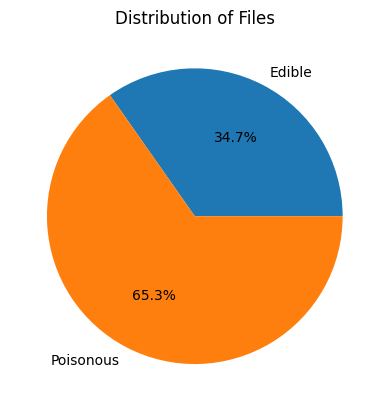

In [7]:
edible_count = 0
poisonous_count = 0

for filename in skimage_collection.files:
    if os.path.basename(filename).startswith('edible'):
        edible_count += 1
    elif os.path.basename(filename).startswith('poisonous'):
        poisonous_count += 1

print("Number of files starting with 'edible':", edible_count)
print("Number of files starting with 'poisonous':", poisonous_count)

labels = ['Edible', 'Poisonous']
counts = [edible_count, poisonous_count]

# Create a pie chart
plt.pie(counts, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Distribution of Files')

# Display the chart
plt.show()

#### Around one third of the image collection contains edible mushrooms.

## There are images with watermarks and others without.  Here's one without watermarks:

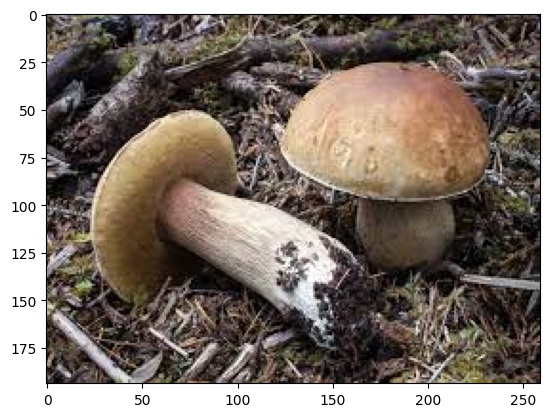

In [8]:
plt.imshow(skimage_collection[3])
plt.show()

## This image is quite good, showing both top view and underside with gills exposed.

## Here's an example of an image with watermarks, banner on the bottom edge, and distracting background shapes.

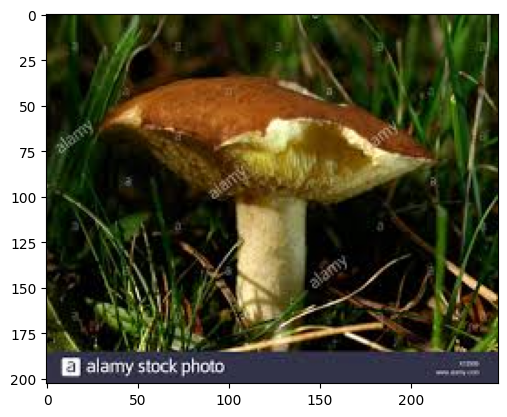

In [9]:
plt.imshow(skimage_collection[1])
plt.show()

## In an effort to clean this image, I'll try using inpaint to cover the banner and four "alamy" with inpaint.

In [10]:
skimage_collection[1].shape

(203, 248, 3)

In [11]:
image_path = skimage_collection.files[1]
print(image_path)

/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/edible_mushroom_sporocarp/edible_mushroom_sporocarp (2).jpg


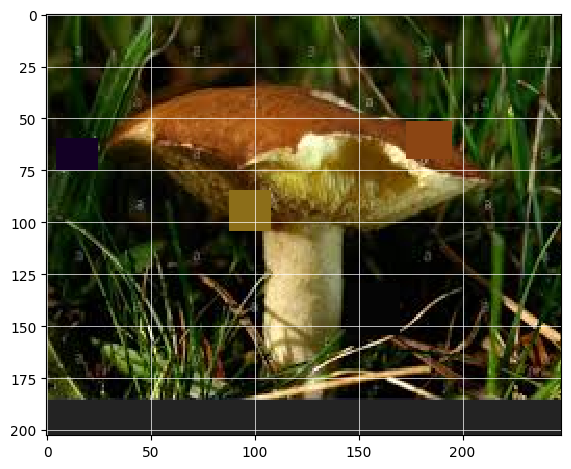

In [28]:
image = io.imread(image_path)

# Create a mask of the region to be inpainted
mask = np.zeros(image.shape[:3], dtype=np.uint8)
mask2 = np.zeros(image.shape[:3], dtype=np.uint8)
mask3 = np.zeros(image.shape[:3], dtype=np.uint8)
mask4 = np.zeros(image.shape[:3], dtype=np.uint8)
mask5 = np.zeros(image.shape[:3], dtype=np.uint8)

#mask[y values, x values]
mask[186:203, 0:248] = 1
mask2[60:76, 5:25] = 1
mask3[85:105, 88:108] = 1
mask4[130:155, 145:170] = 1
mask5[52:70, 173:195] = 1

# Inpaint the image trying best to match surrounding pixel colors
inpainted_image = np.copy(image)

r, g, b = inpainted_image[35, 40]
inpainted_image[np.where(mask)] = 35
indices2 = np.where(mask2)
inpainted_image[indices2[0], indices2[1], :] = [r, b, g]



indices3 = np.where(mask3)
inpainted_image[indices3[0], indices3[1], :] = [140, 110, 25]

inpainted_image[np.where(mask4)] = 5

indices5 = np.where(mask5)
inpainted_image[indices5[0], indices5[1], :] = [139, 69, 19]

# Save the output
#imsave('inpaint_output.jpg', img_as_ubyte(inpaint_image))

# Display the inpainted image
io.imshow(inpainted_image)
plt.grid(True, color='white', linewidth=0.5)
io.show()

## It's entertaining to construct, but the process is not scalable.

## Below is an attempt clean the image using inpaint_biharmonic.

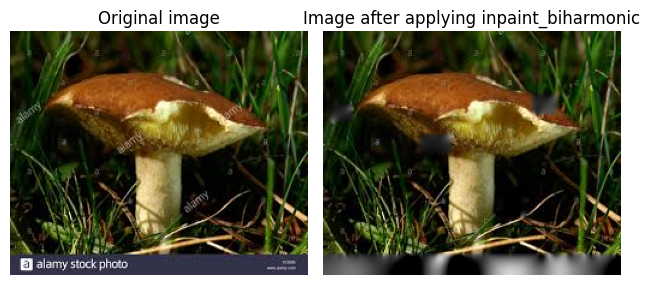

In [13]:
image2 = io.imread(image_path)

# Initialize the mask
mask = np.zeros(image.shape[:3], dtype=np.uint8)
mask2 = np.zeros(image.shape[:3], dtype=np.uint8)
mask3 = np.zeros(image.shape[:3], dtype=np.uint8)
mask4 = np.zeros(image.shape[:3], dtype=np.uint8)
mask5 = np.zeros(image.shape[:3], dtype=np.uint8)

# Set the pixels where the logo is to 1
mask[186:203, 0:248] = 1 
mask2[60:76, 5:25] = 1
mask3[85:103, 80:108] = 1
mask4[130:155, 145:170] = 1
mask5[52:70, 173:195] = 1

total_mask = mask | mask2 | mask3 | mask4 | mask5

# Perform inpainting
output_image = inpaint_biharmonic(image2, total_mask)

# Save the output
#imsave('biharmonic_output.jpg', img_as_ubyte(output_image))

# Optionally, display the images
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(image)
axes[0].set_title('Original image')
axes[1].imshow(output_image)
axes[1].set_title('Image after applying inpaint_biharmonic')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## The background is quite busy so I'd like to tune out some of it out by denoise_tv_chambolle

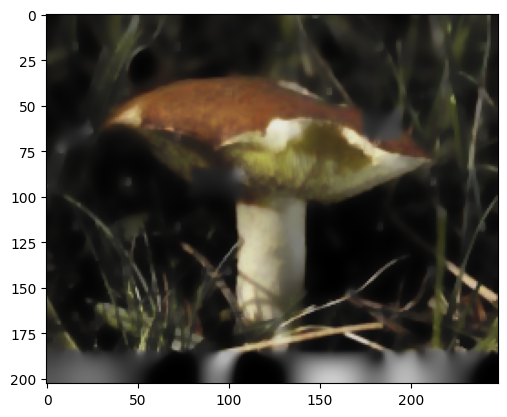

In [14]:
from skimage.restoration import denoise_tv_chambolle

denoised_image = denoise_tv_chambolle(output_image)

plt.imshow(denoised_image)
plt.show;

## Now applying try_all_threshold to the denoised image.

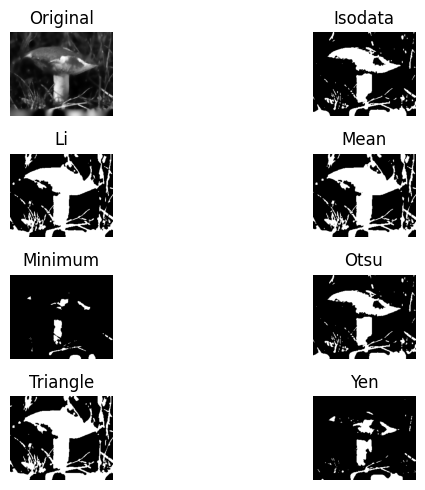

In [15]:

# Turn the fruits_image to grayscale
grayscale = rgb2gray(denoised_image)

# Use the try all method on the resulting grayscale image
fig, ax = try_all_threshold(grayscale, verbose=False)

# Show the resulting plots
plt.show();

#### Otsu and Isodata seem to be the most effective.

## For further refining, I want to run the Otsu image through contours and canny edge detector independently.

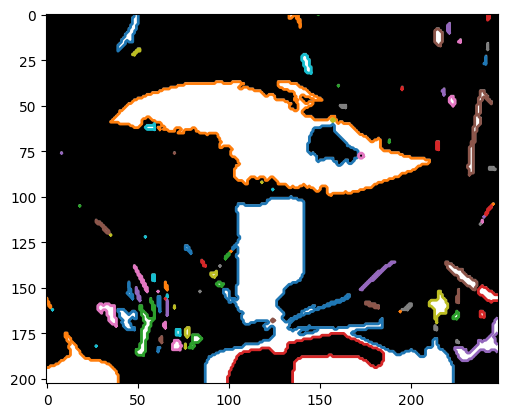

In [16]:
from skimage.filters import threshold_otsu

# Make the image grayscale using rgb2gray
image3 = rgb2gray(denoised_image)

# Obtain the optimal threshold value with otsu
thresh = threshold_otsu(image3)

# Apply thresholding to the image
thresh_otsu = image3 > thresh

# Find the contours with a constant level value of 0.8
contours = measure.find_contours(thresh_otsu, 0.9)

# Initialize a new plot
fig, ax = plt.subplots()

# Show the image
ax.imshow(thresh_otsu, cmap=plt.cm.gray)

# Plot the contours
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

# Show the plot
plt.show();

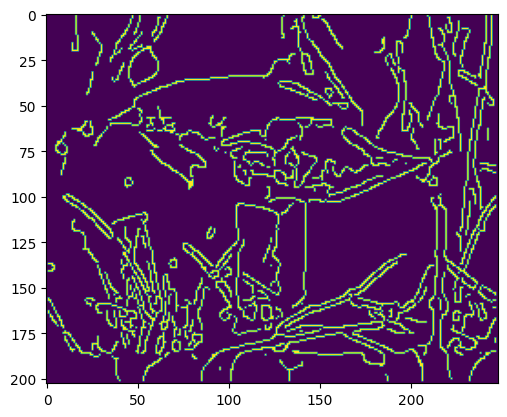

In [17]:
# Import the canny edge detector 
from skimage.feature import canny

# Convert image to grayscale
image4 = color.rgb2gray(denoised_image)

# Apply canny edge detector
canny_edges = canny(image4)

# Show resulting image
plt.imshow(canny_edges)
plt.show;

## Next, I will analyze the distribution of pixel intensities across each RGB channel.

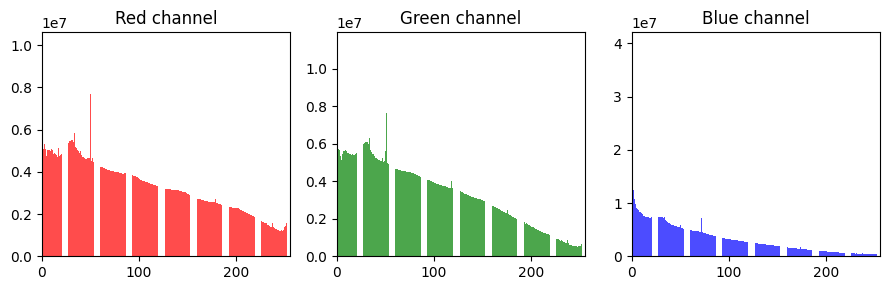

In [18]:
# Initialize arrays to hold all pixel histograms of each channel
hist_r = np.zeros(256)
hist_g = np.zeros(256)
hist_b = np.zeros(256)

for img in skimage_collection:
    
    # Check if image has more than 3 channels and take only first three if true
    if img.shape[2] > 3:
        img = img[:, :, :3]

    # Split the image into its respective channels
    r, g, b = cv2.split(img)
    
    # Compute histogram for each channel and accumulate
    hist_r += np.histogram(r, bins=256, range=[0,256])[0]
    hist_g += np.histogram(g, bins=256, range=[0,256])[0]
    hist_b += np.histogram(b, bins=256, range=[0,256])[0]

# Prepare bins for histogram
bins = np.arange(256)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# Plot histogram for Red channel
axs[0].bar(bins, hist_r, color='red', alpha=0.7)
axs[0].set_title('Red channel')
axs[0].set_xlim([0,256])

# Plot histogram for Green channel
axs[1].bar(bins, hist_g, color='green', alpha=0.7)
axs[1].set_title('Green channel')
axs[1].set_xlim([0,256])

# Plot histogram for Blue channel
axs[2].bar(bins, hist_b, color='blue', alpha=0.7)
axs[2].set_title('Blue channel')
axs[2].set_xlim([0,256])

# Show the plot
plt.tight_layout()
plt.show()


## Blue shades are a lot less prevalent compared to reds and greens.

## Resizing images to (256,256) and putting them into a new list titled resized_images.

In [19]:
new_size = (256, 256)

# Create a list to store the resized images
resized_images = []

# Iterate over the images in the collection
for image in skimage_collection:
    # Resize the image
    resized_image = resize(image, new_size)
    # Append the resized image to the list
    resized_images.append(resized_image)

# Print the number of resized images
print(f"Number of resized images: {len(resized_images)}")


Number of resized images: 3400
